# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нам нужно определить рыночную стоимость объектов недвижимости. Для этого проведём исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None) #отменим ограничения на отображение всех 
                                            #столбцов, чтобы видеть всю таблицу

data = pd.read_csv('/Users/dmitrynikolaev/Documents/datasets/real_estate_data.csv', sep='\t')
data.info()
data.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Видим количество строк, названия столбцов, тип данных в них, количество ненулевых строк (и соответственно пропусков, понимаем что они есть и где, подробнее рассмотрим дальше в разделе предобработки). Построим гистограмму для всех числовых столбцов таблицы на одном графике

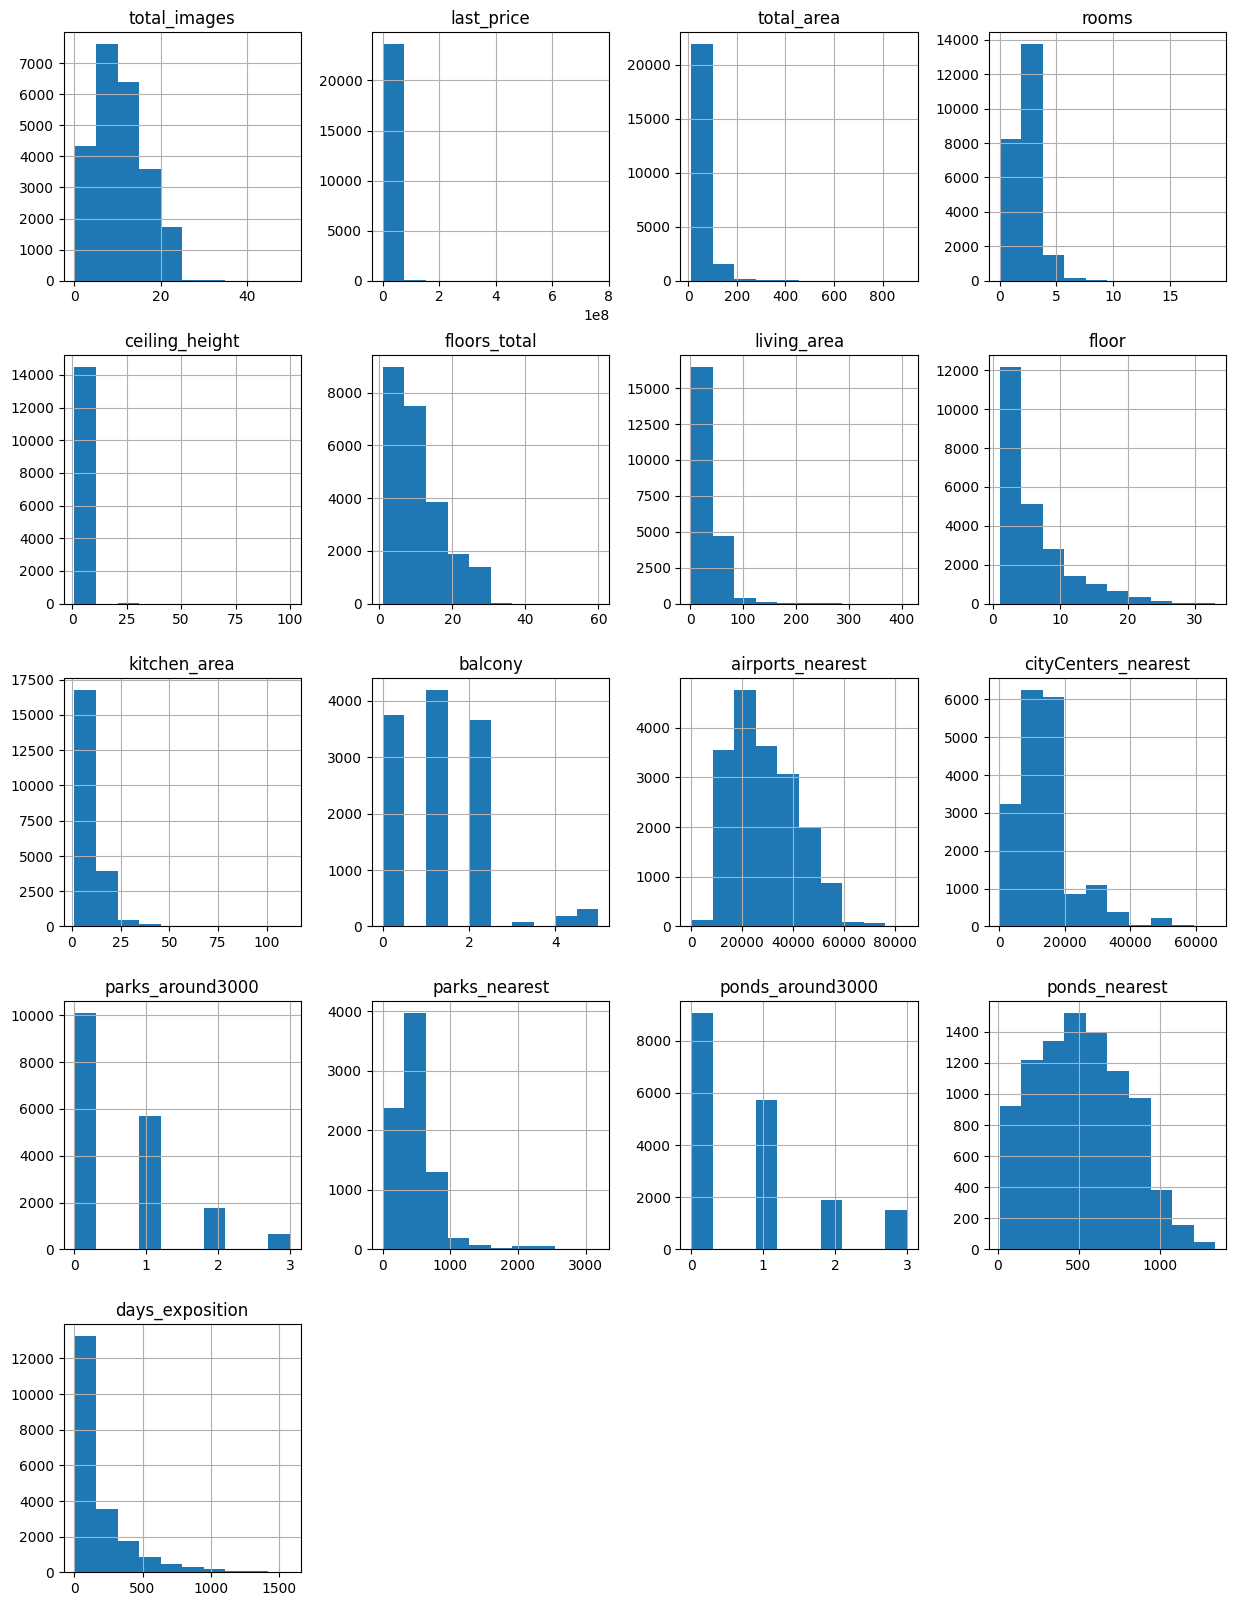

In [3]:
data.hist(figsize=(15,20))
plt.show()

По гистограммам оценили основные значения в столбцах и их количество

## Выполним предобработку данных

**Задача 1** *Найдём и изучим пропущенные значения в столбцах:   
Определим, в каких столбцах есть пропуски.  
Заполним пропущенные значения там, где это возможно. Например, если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски можно заменить на число 0. Если логичную замену предложить не получится, то оставим пропуски. Пропущенные значения — тоже важный сигнал, который нужно учитывать.*  
___


По info() выше видим пропуски в столбцах, где количество ненулевых значений отличается от общего количества строк 23699:  
Заполним:  
balcony - количество балконов - пропуски заполним нулём, поэтому и не указали, потому что их нет  
is_apartment - булев тип апартаментов - пропуски можем заполнить на false, при продаже квартир скорее всего просто не заполняли  

Пропустим:  
ceiling_height - высота потолков - она везде разная, по среднему или медиане не корректно заполнять. Не заполняли возможно потому, что не знали точные цифры.  
floors_total - всего этажей, возможно посчитали неважной информацией, locality_name - населённый пункт,возможно пропустили, заполнив дальше адрес, начиная с улицы, - есть незначительное количество пропусков, можно оставить, заполнить чем-то не сможем  
living_area - жилая площадь - не понятно почему не указали, ведь от неё напрямую зависит цена  
kitchen_area - площадь кухни - средним не заполним, кухни везде разные, продавец видимо не знает или просто указал только общую площадь  
Автоматически заполненные данные - airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest - расстояние до центра, аэропорта, парков и водоёмов - не заполнены скорее всего потому, что в базе нет либо самих данных, либо адресов продаваемых квартир  
days_exposition - срок размещения объявления - около 14% пропусков, по идее должен считаться автоматически, возможно сбой какой-то в базе

Заполним пропуски в количестве балконов и флаге апартаментов

In [4]:
# Столбец балконов
print('Количество пропусков', data['balcony'].isna().sum())
data['balcony'] = data['balcony'].fillna(0)
print('Количество пропусков после устранения', data['balcony'].isna().sum())
print('Уникальные значения:', data['balcony'].unique())

Количество пропусков 11519
Количество пропусков после устранения 0
Уникальные значения: [0. 2. 1. 5. 4. 3.]


In [5]:
# Столбец апартаментов
print('Количество пропусков', data['is_apartment'].isna().sum())
data['is_apartment'] = data['is_apartment'].fillna(False)
print('Количество пропусков после устранения', data['is_apartment'].isna().sum())
print('Уникальные значения:', data['is_apartment'].unique())

Количество пропусков 20924
Количество пропусков после устранения 0
Уникальные значения: [False  True]


/var/folders/qm/npnmpfw50z7_yqn218qvz3m40000gn/T/ipykernel_1487/342155079.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


___
**Задача 2** *Рассмотрим типы данных в каждом столбце:   
Найдём столбцы, в которых нужно изменить тип данных.  
Преобразуем тип данных в выбранных столбцах.*
___

В столбце first_day_exposition заполнена дата публикации, изменим тип на date_time

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

В столбцах floors_total, balcony, parks_around3000, ponds_around3000 и days_exposition заполнены соответствующие количества, вещественного числа там быть не может, изменим тип на int

In [7]:
for column in ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition']:
    data[column] = data[column].astype('int', errors='ignore')
data.info() #проверяем результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Изменился тип только у полного столбца с количеством балконов, поскольку в столбце данные могут иметь только один тип, а NaN - это float, перевести NaN к типу int не получится. Из-за этого тип остальных выше перечисленных столбцов остается float даже с errors='ignore'

___
**Задача 3** *Изучим уникальные значения в столбце с названиями и устраните неявные дубликаты.*
___

Посмотрим уникальные значения в столбце в названиями и их количество

In [8]:
#pd.set_option('display.max_rows', None) #временно отменим ограничения на отображение всех строк, чтобы пролистать весь список
data['locality_name'].value_counts()

locality_name
Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: count, Length: 364, dtype: int64

Заменим ё на е и объединим названия поселков, убрав "городского типа" и "городской", чтобы исключить дубликаты

In [9]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].replace(['поселок городского типа','городской поселок'], 'поселок',regex=True)
len(data['locality_name'].value_counts())

322

Заменили и проверили, что число названий стало меньше

## Добавим в таблицу новые столбцы

**Задача добавить столбцы:**
- цена одного квадратного метра;  
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);  
- месяц публикации объявления;  
- год публикации объявления;  
- тип этажа квартиры (значения — «первый», «последний», «другой»);  
- расстояние до центра города в километрах;
___

In [10]:
data['last_price_m2'] = (data['last_price']/data['total_area']).round(2)
data['weekday_exp'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month_exp'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_exp'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round()

In [11]:
def floor_type(data):
    floor = data['floor']
    floors_total = data['floors_total']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'   
    return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)

In [12]:
data.head(20) #проверяем добавление и содержание новых столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,16.0,другой
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018,19.0,первый
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,14.0,другой
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,7.0,другой
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,8.0,другой
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.40,5,False,False,False,9.10,0,поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.79,0,9,2018,NaN,другой
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.60,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.71,3,11,2017,19.0,другой
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,NaN,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.69,3,4,2019,12.0,другой
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.43,26,False,False,False,8.81,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.76,2,5,2018,NaN,другой
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.59,6,2,2017,15.0,другой


## Проведём исследовательский анализ данных

**Задача 1** *Изучим перечисленные ниже параметры объектов и построим отдельные гистограммы для каждого из этих параметров. В некоторых параметрах встречаются редкие и выбивающиеся значения, проанализируем их.
Список параметров:  
общая площадь;  
жилая площадь;  
площадь кухни;  
цена объекта;  
количество комнат;    
высота потолков;  
тип этажа квартиры («первый», «последний», «другой»);  
общее количество этажей в доме;  
расстояние до центра города в метрах;  
расстояние до ближайшего парка.*

Выведем и оценим числовое описание данных в столбцах

In [13]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
total_images,23699.0,9.858475,0.0,6.0,9.0,14.0,50.0,5.682529
last_price,23699.0,6541548.771552,12190.0,3400000.0,4650000.0,6800000.0,763000000.0,10887013.267545
total_area,23699.0,60.348651,12.0,40.0,52.0,69.9,900.0,35.654083
first_day_exposition,23699,2017-11-08 21:55:18.975484160,2014-11-27 00:00:00,2017-05-12 12:00:00,2017-12-12 00:00:00,2018-08-26 00:00:00,2019-05-03 00:00:00,NaN
rooms,23699.0,2.070636,0.0,1.0,2.0,3.0,19.0,1.078405
ceiling_height,14504.0,2.771499,1.0,2.52,2.65,2.8,100.0,1.261056
floors_total,23613.0,10.673824,1.0,5.0,9.0,16.0,60.0,6.597173
living_area,21796.0,34.457852,2.0,18.6,30.0,42.3,409.7,22.030445
floor,23699.0,5.892358,1.0,2.0,4.0,8.0,33.0,4.885249
kitchen_area,21421.0,10.569807,1.3,7.0,9.1,12.0,112.0,5.905438


Обратим внимание на минимум и максимум столбца с ценой, строки с нулевым значением комнат, аномально маленькие значения жилой и кухонной площади, аномальные значения высоты потолков. Остальные столбцы рассмотрим позже

Построим гисторамму цен с диапазоном до 75%

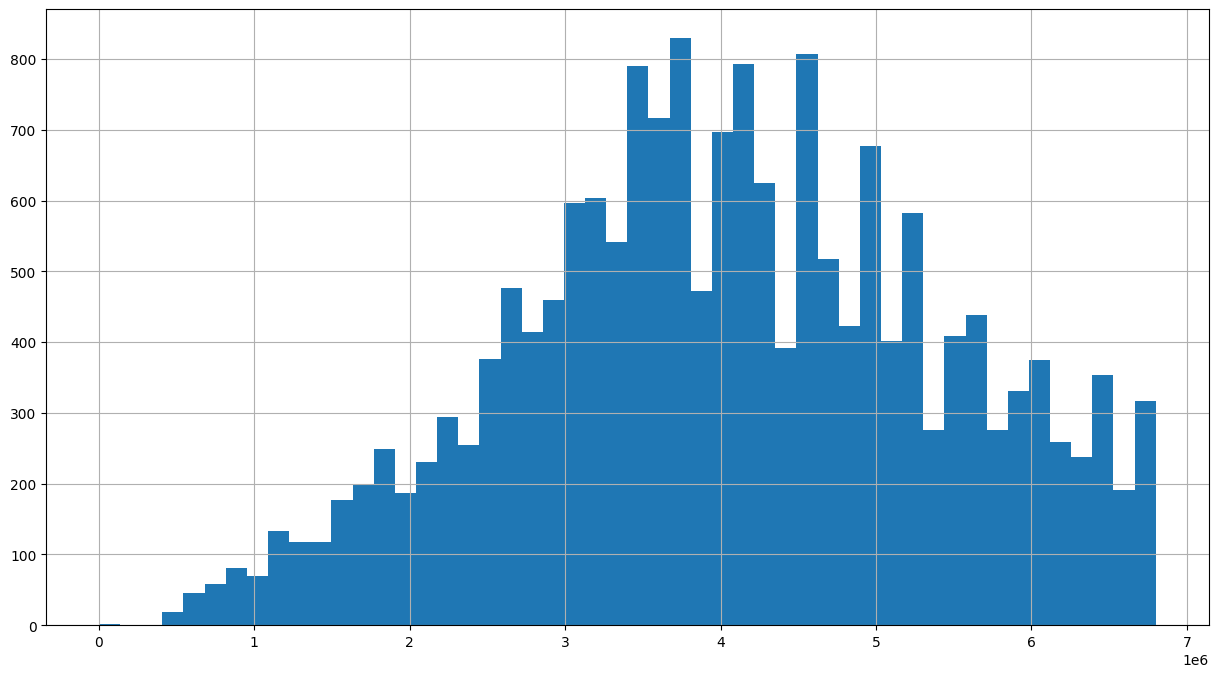

In [14]:
data['last_price'].hist(bins=50, range=(0, 6.8e6), figsize=(15,8))
plt.show()

In [15]:
data.query('last_price>1e7').head(30)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,16.0,другой
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,7.0,другой
19,16,14200000.0,121.0,2019-01-09,3,2.75,16.0,76.00,8,False,False,False,12.00,0,Санкт-Петербург,38900.0,12843.0,0.0,NaN,0.0,NaN,97.0,117355.37,2,1,2019,13.0,другой
35,6,15500000.0,149.0,2017-06-26,5,NaN,5.0,104.00,4,False,False,False,17.00,0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0,104026.85,0,6,2017,4.0,другой
42,13,22000000.0,161.8,2015-07-08,4,2.80,4.0,80.90,2,False,False,False,17.60,5,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0,135970.33,2,7,2015,31.0,другой
51,7,45000000.0,161.0,2017-10-17,3,3.20,8.0,38.00,4,False,False,False,50.00,0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0,279503.11,1,10,2017,7.0,другой
52,20,11795000.0,136.0,2017-09-22,6,3.00,2.0,94.00,2,False,False,False,11.00,1,Санкт-Петербург,16510.0,6582.0,1.0,526.0,0.0,NaN,NaN,86727.94,4,9,2017,7.0,последний
63,2,20000000.0,118.0,2018-09-11,3,3.00,9.0,68.00,7,False,False,False,16.00,0,Санкт-Петербург,26055.0,4800.0,1.0,648.0,1.0,779.0,37.0,169491.53,1,9,2018,5.0,другой
81,9,10949000.0,68.0,2018-12-27,1,NaN,10.0,NaN,6,False,False,False,NaN,0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161014.71,3,12,2018,NaN,другой
98,11,11700000.0,80.0,2014-12-10,3,NaN,5.0,55.10,3,False,False,False,11.00,0,Санкт-Петербург,11248.0,8767.0,1.0,666.0,0.0,NaN,831.0,146250.00,2,12,2014,9.0,другой


<Axes: >

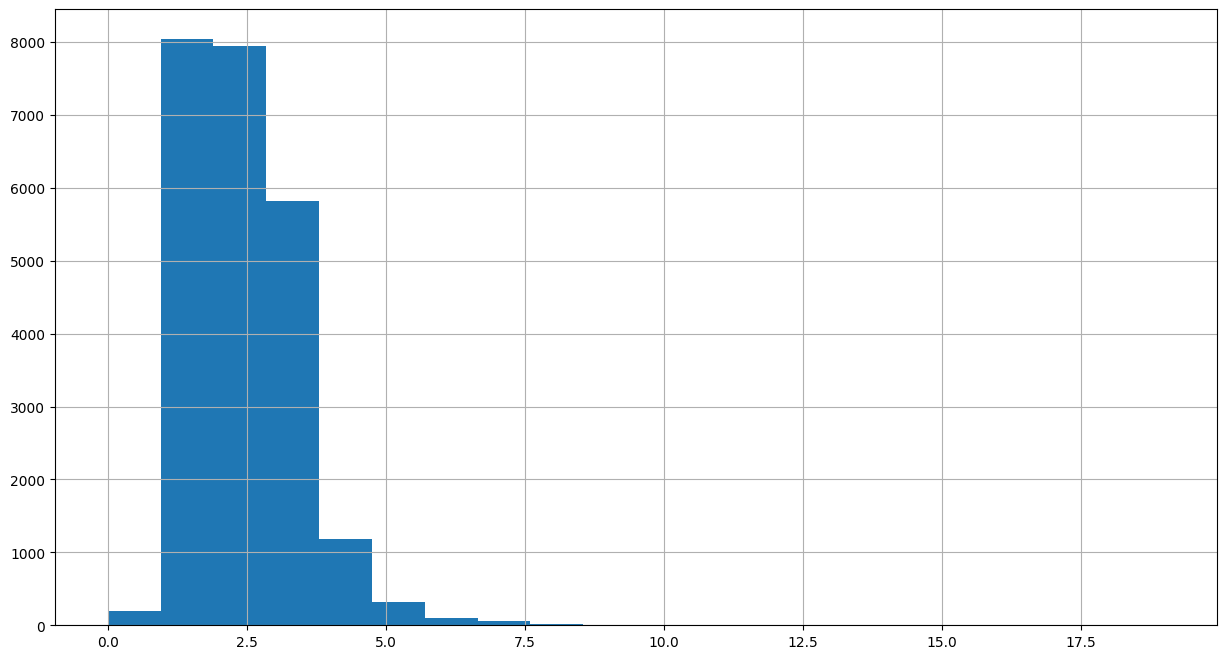

In [16]:
data['rooms'].hist(bins=20, figsize=(15,8))

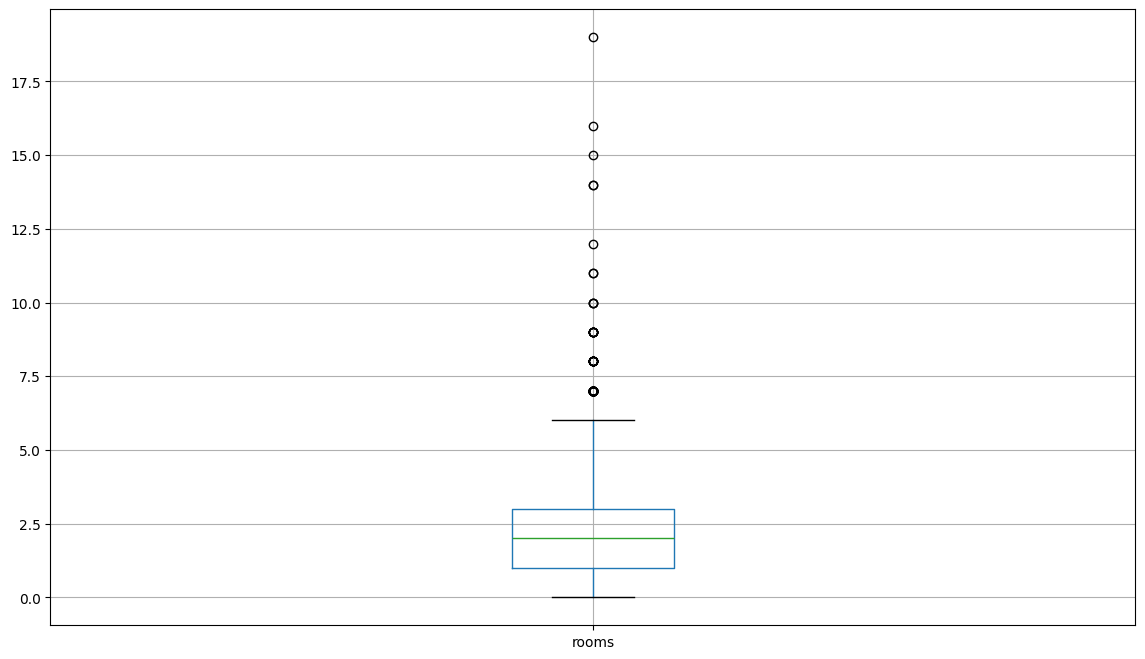

In [17]:
rooms=data.boxplot(column='rooms', figsize='14,8')

Оценим объявления с большим количеством комнат

In [18]:
data.query('rooms>6').head(30)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
581,20,65000000.0,365.0,2019-03-18,7,2.90,7.0,NaN,7,False,False,False,NaN,0,Санкт-Петербург,19827.0,1690.0,3.0,378.0,3.0,58.0,NaN,178082.19,0,3,2019,2.0,последний
648,3,17500000.0,183.7,2018-07-01,11,3.40,7.0,138.8,7,False,False,False,13.3,0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN,95264.02,6,7,2018,3.0,последний
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,False,False,False,26.4,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0,103223.81,2,10,2017,1.0,другой
681,20,24900000.0,249.0,2015-08-13,7,NaN,5.0,180.0,4,False,False,False,NaN,1,Санкт-Петербург,24810.0,6108.0,0.0,NaN,0.0,NaN,781.0,100000.00,3,8,2015,6.0,другой
750,9,29500000.0,188.8,2017-03-04,7,2.70,2.0,119.3,1,False,False,False,10.2,0,Санкт-Петербург,20965.0,814.0,0.0,NaN,2.0,267.0,246.0,156250.00,5,3,2017,1.0,первый
813,7,16500000.0,229.0,2016-02-25,8,NaN,6.0,160.0,5,False,False,False,25.0,0,Санкт-Петербург,23968.0,4536.0,1.0,243.0,0.0,NaN,806.0,72052.40,3,2,2016,5.0,другой
855,18,15000000.0,134.0,2017-10-27,7,NaN,4.0,88.0,3,False,False,False,12.0,0,Санкт-Петербург,22670.0,3936.0,1.0,803.0,1.0,387.0,150.0,111940.30,4,10,2017,4.0,другой
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,False,False,False,16.6,0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0,68870.52,5,12,2017,8.0,другой
1494,10,65000000.0,364.0,2018-11-27,7,3.90,6.0,250.0,3,False,False,False,20.0,0,Санкт-Петербург,21988.0,3254.0,0.0,NaN,1.0,689.0,46.0,178571.43,1,11,2018,3.0,другой
1813,0,15000000.0,179.0,2017-04-09,7,NaN,5.0,126.4,5,False,False,False,20.9,0,Санкт-Петербург,20070.0,3186.0,1.0,104.0,1.0,803.0,15.0,83798.88,6,4,2017,3.0,последний


Большое количество комнат можно связать с большой площадью и соотвественно с большой ценой, к тому же такие квартиры находятся в городах близко к центру  
Далее рассмотрим строки с низкими ценами до миллиона

In [19]:
data.query('last_price<1e6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
164,6,800000.0,40.3,2018-06-25,2,NaN,3.0,NaN,1,False,False,False,NaN,2,поселок Ефимовский,NaN,NaN,NaN,NaN,NaN,NaN,81.0,19851.12,0,6,2018,NaN,первый
247,7,650000.0,31.0,2017-01-20,1,NaN,3.0,NaN,1,False,False,False,NaN,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,378.0,20967.74,4,1,2017,NaN,первый
259,6,900000.0,30.0,2017-11-21,1,2.5,5.0,15.0,4,False,False,False,5.0,1,Ивангород,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.00,1,11,2017,NaN,другой
268,7,650000.0,46.0,2018-03-15,2,2.5,5.0,30.0,5,False,False,False,7.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,75.0,14130.43,3,3,2018,NaN,последний
293,2,900000.0,42.8,2017-06-14,2,NaN,5.0,32.0,5,False,False,False,5.0,0,Сясьстрой,NaN,NaN,NaN,NaN,NaN,NaN,247.0,21028.04,2,6,2017,NaN,последний
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23067,8,600000.0,31.8,2019-04-24,1,NaN,2.0,20.0,1,False,False,False,7.0,0,деревня Коркино,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18867.92,2,4,2019,NaN,первый
23153,9,650000.0,41.0,2017-10-13,2,NaN,3.0,28.0,1,False,False,False,6.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,14.0,15853.66,4,10,2017,NaN,первый
23354,18,900000.0,42.6,2018-02-26,2,NaN,2.0,28.0,1,False,False,False,9.0,0,деревня Тихковицы,NaN,NaN,NaN,NaN,NaN,NaN,219.0,21126.76,0,2,2018,NaN,первый
23484,11,470000.0,44.5,2018-07-02,2,NaN,2.0,28.0,2,False,False,False,7.5,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,298.0,10561.80,0,7,2018,NaN,последний


Дешёвых квартир не много, возможно их состояние или состояние дома так влияет на цену. Удалять строки с очень низкой ценой не будем, потому что сложно оценить порог этой цены, понять какие ошибочные, а какие реально по каким-то причинам занижены.

Далее рассмотрим объявления с нулевым значением количества комнат

In [20]:
data.query('rooms==0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
144,1,2450000.0,27.00,2017-03-30,0,NaN,24.0,15.50,2,False,True,False,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0,90740.74,3,3,2017,NaN,другой
349,4,2320000.0,25.00,2017-09-27,0,NaN,14.0,17.00,1,False,False,True,NaN,0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,92800.00,2,9,2017,NaN,первый
440,8,2480000.0,27.11,2018-03-12,0,NaN,17.0,24.75,4,False,True,False,NaN,2,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,91479.16,0,3,2018,15.0,другой
508,0,3375000.0,34.40,2017-03-28,0,NaN,26.0,24.30,19,False,False,True,NaN,1,поселок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,98110.47,1,3,2017,19.0,другой
608,2,1850000.0,25.00,2019-02-20,0,NaN,10.0,NaN,7,False,True,False,NaN,0,поселок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0,74000.00,2,2,2019,NaN,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01,0,NaN,25.0,18.00,16,False,True,False,NaN,0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0,123076.92,4,9,2017,13.0,другой
23442,0,2500000.0,27.70,2017-09-28,0,NaN,24.0,18.00,4,False,False,True,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0,90252.71,3,9,2017,NaN,другой
23554,15,3350000.0,26.00,2018-09-07,0,NaN,19.0,NaN,8,False,True,False,NaN,0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0,128846.15,4,9,2018,17.0,другой
23592,10,1450000.0,29.00,2017-11-11,0,NaN,9.0,18.00,8,False,False,True,NaN,2,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0,50000.00,5,11,2017,NaN,другой


In [21]:
data.query('rooms==0').groupby('studio')['rooms'].count()

studio
False     59
True     138
Name: rooms, dtype: int64

Небольшое количество объявлений, где не указано количество комнат, при этом можно было бы предположить, что это только студии, но нет.. Поэтому удалим их

In [22]:
data=data.query('rooms!=0')

Далее рассмотрим общую площадь, жилую и кухонную

<Axes: ylabel='Frequency'>

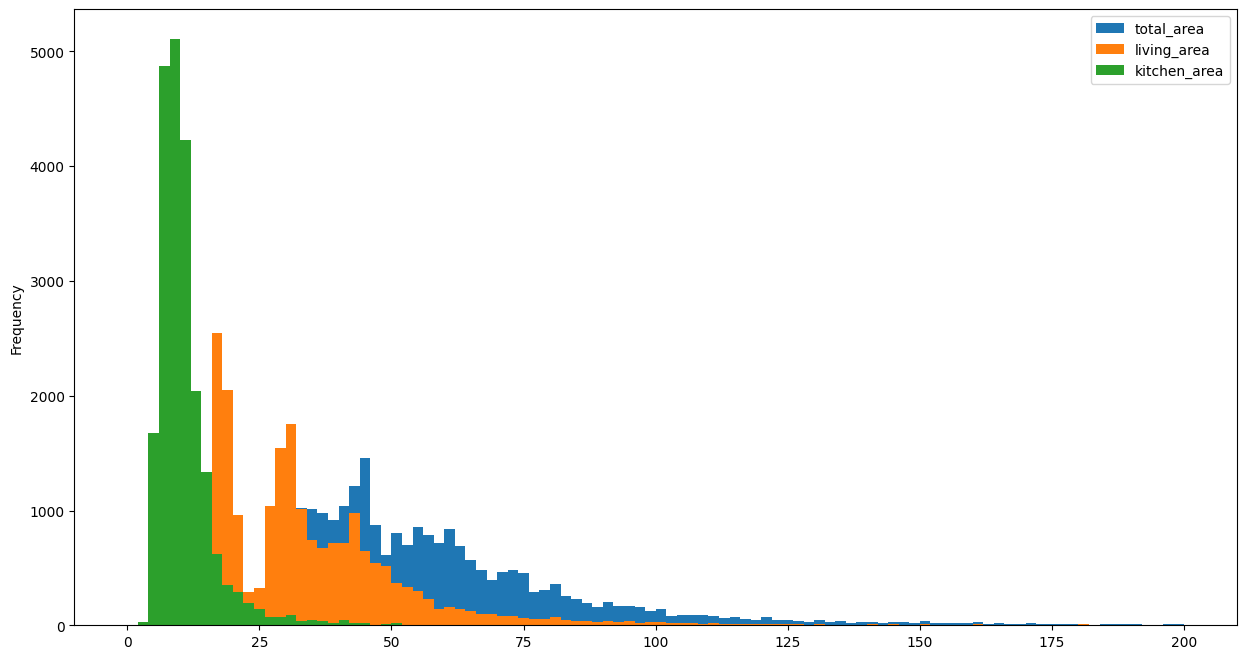

In [23]:
data[['total_area','living_area','kitchen_area']].plot(bins=100, range=(0, 200), figsize=(15,8), kind='hist')

Прослеживается прямая зависимость жилой и кухонной площади от общей, а совсем маленькие значение жилой площади могут быть например в студиях

Далее рассмотрим столбец высоты потолков. Построим гистограмму с диапазoном до 75%

<Axes: >

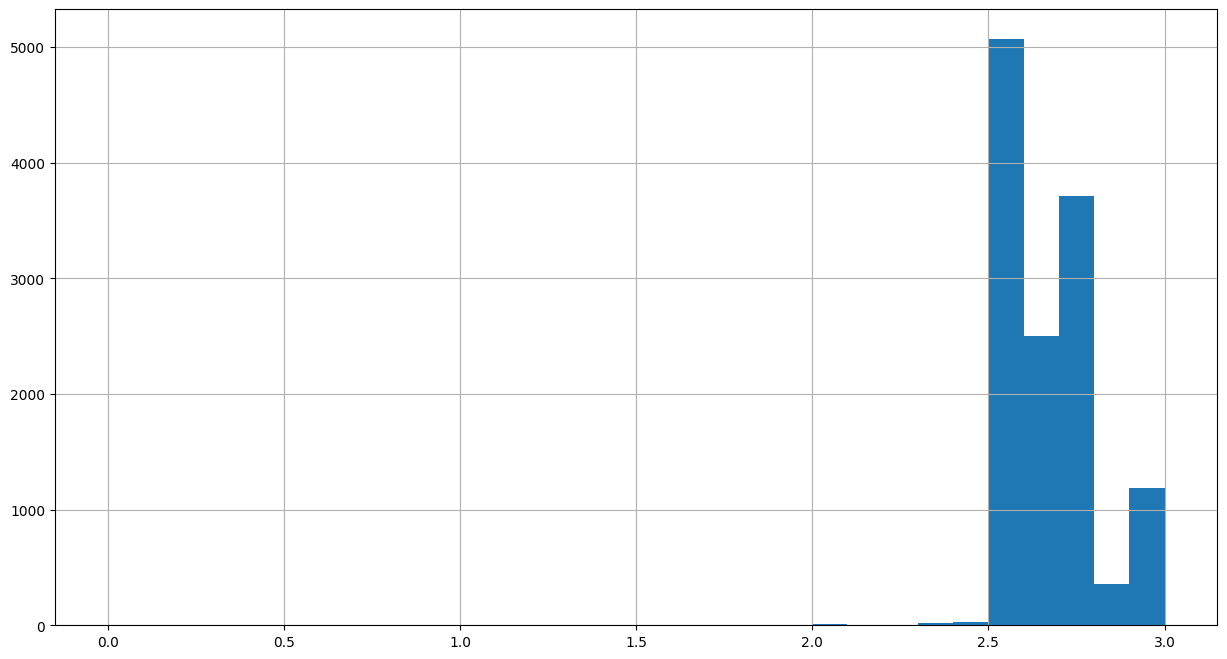

In [24]:
data['ceiling_height'].hist(bins=30, range=(0,3), figsize=(15,8))

И с диапазoном от 75%, чтобы оценить аномальное высокие значения

(0.0, 100.0)

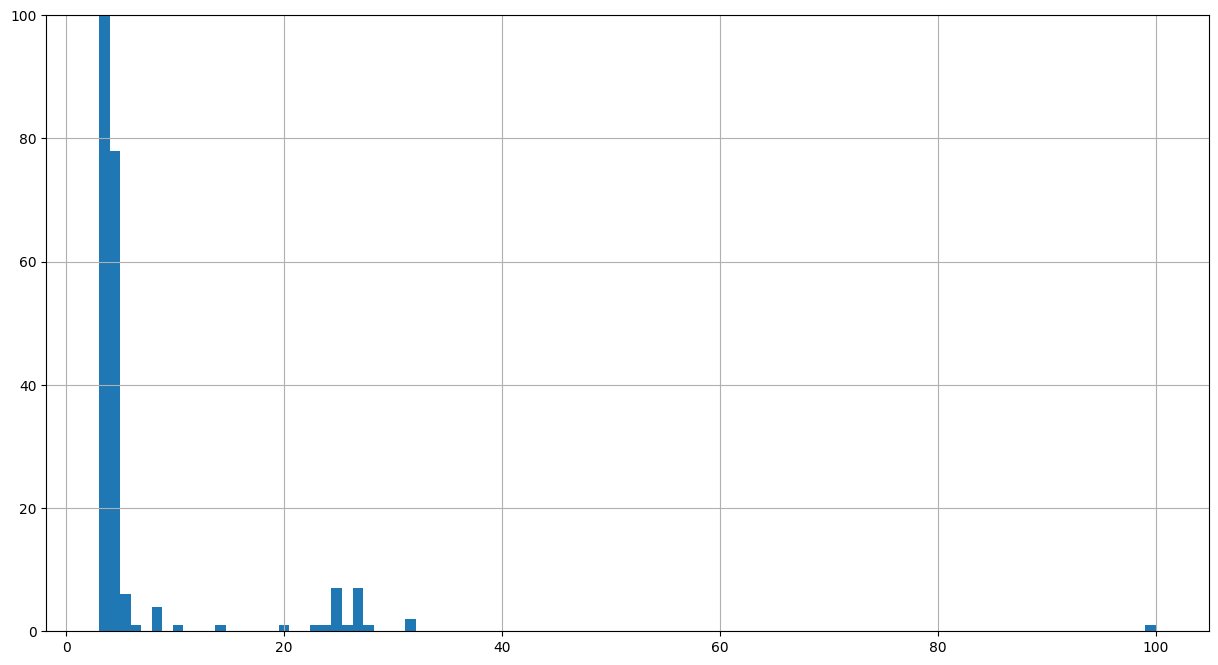

In [25]:
data['ceiling_height'].hist(bins=100, range=(3,100), figsize=(15,8))
plt.ylim([0, 100])

Посчитаем количество строк со значением высоты потолков от 20 до 30. Предполагая, что они указаны ошибочно вместо 2-3, то есть без запятой, исправим эти значения, поделив на 10. А строку со значением 100 удалим

In [26]:
data=data.query('ceiling_height!=100')
len(data.query('ceiling_height>20'))

20

In [27]:
data.query('ceiling_height>20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,False,False,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0,65217.39,3,7,2018,NaN,другой
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,False,False,False,8.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38666.67,0,11,2018,NaN,другой
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,False,False,False,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0,95555.56,3,2,2018,13.0,другой
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,False,False,5.5,0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0,126229.51,2,10,2018,8.0,первый
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,False,False,False,9.0,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,46296.30,4,10,2017,NaN,другой
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,False,False,False,7.0,2,Санкт-Петербург,28981.0,10912.0,1.0,305.0,0.0,NaN,267.0,88000.00,1,8,2017,11.0,другой
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,False,False,False,12.0,5,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,101875.00,2,1,2019,20.0,другой
6246,6,3300000.0,44.4,2019-03-25,2,25.0,5.0,31.3,5,False,False,False,5.7,0,Кронштадт,68923.0,50649.0,1.0,417.0,2.0,73.0,NaN,74324.32,0,3,2019,51.0,последний
9379,5,3950000.0,42.0,2017-03-26,3,25.0,5.0,30.0,2,False,False,False,5.2,0,Санкт-Петербург,11647.0,13581.0,0.0,NaN,0.0,NaN,NaN,94047.62,6,3,2017,14.0,другой
10773,8,3800000.0,58.0,2017-10-13,2,27.0,10.0,30.1,3,False,False,False,8.1,2,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0,65517.24,4,10,2017,NaN,другой


In [28]:
data.loc[data['ceiling_height']>20,'ceiling_height'] = (data.loc[data['ceiling_height']>20,'ceiling_height'])/10
data.query('ceiling_height>20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type


In [29]:
# Получили пустой стрез, тогда проверим первые три строки по индексу
data.loc[[355,3148,4643]]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_m2,weekday_exp,month_exp,year_exp,cityCenters_nearest_km,floor_type
355,17,3600000.0,55.2,2018-07-12,2,2.5,5.0,32.0,2,False,False,False,NaN,2,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0,65217.39,3,7,2018,NaN,другой
3148,14,2900000.0,75.0,2018-11-12,3,3.2,3.0,53.0,2,False,False,False,8.0,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38666.67,0,11,2018,NaN,другой
4643,0,4300000.0,45.0,2018-02-01,2,2.5,9.0,30.0,2,False,False,False,7.0,1,Санкт-Петербург,12016.0,13256.0,1.0,658.0,1.0,331.0,181.0,95555.56,3,2,2018,13.0,другой


Дальше рассмотрим столбцы этажей: тип этажа квартиры («первый», «последний», «другой») и общее количество этажей в доме

<Axes: >

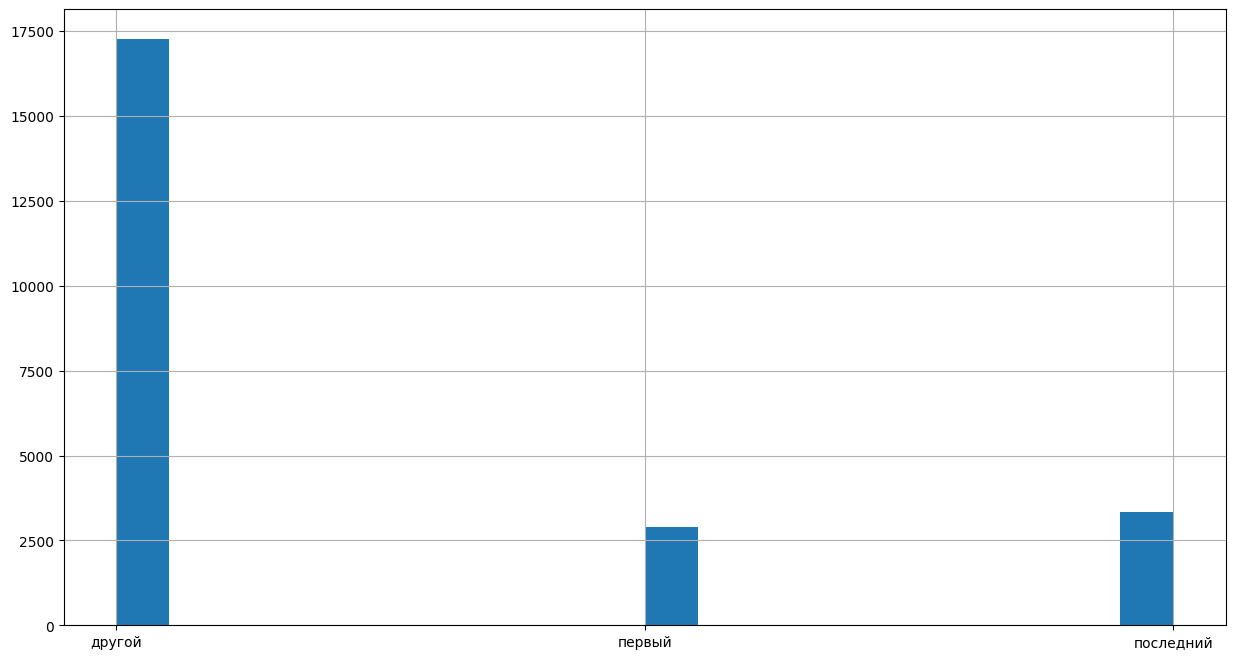

In [30]:
data['floor_type'].hist(bins=20, figsize=(15,8))

Здесь данные вполне предсказуемы, первых с последних этажей гораздо меньше, чем других

<Axes: >

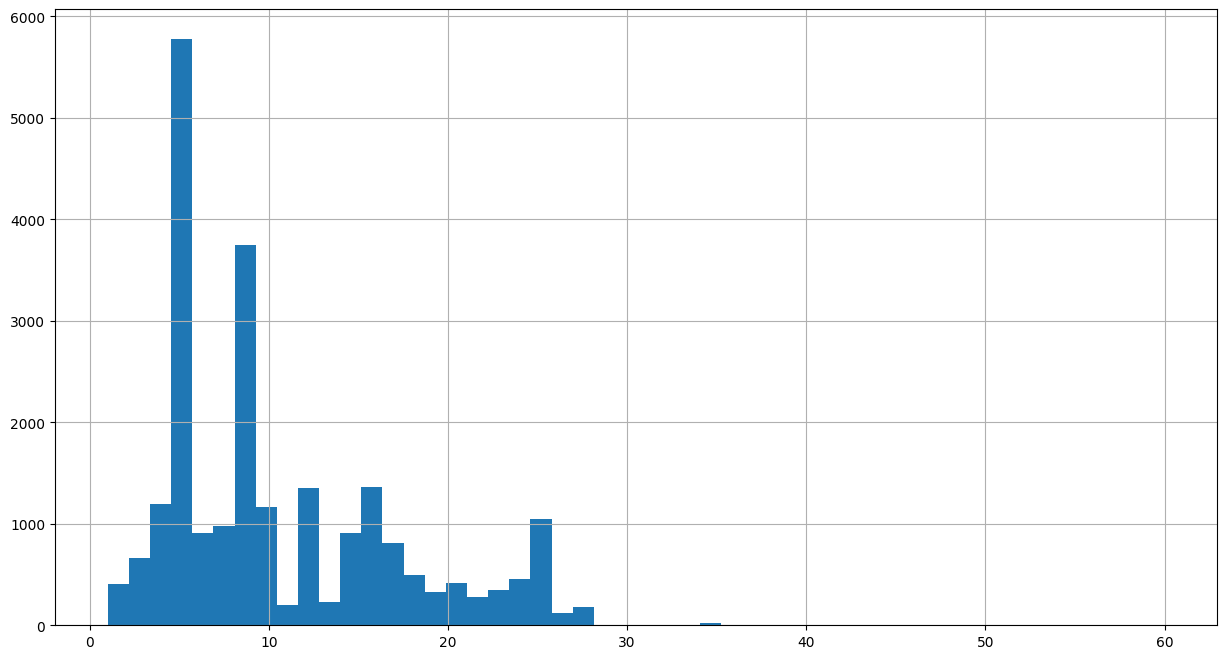

In [31]:
data['floors_total'].hist(bins=50, figsize=(15,8))

In [32]:
print(data['floors_total'].value_counts())

floors_total
5.0     5780
9.0     3749
16.0    1358
12.0    1355
4.0     1195
10.0    1169
25.0    1048
6.0      911
17.0     815
3.0      662
7.0      589
14.0     545
18.0     492
24.0     454
8.0      388
2.0      383
15.0     361
23.0     346
19.0     330
22.0     282
20.0     265
13.0     229
11.0     200
27.0     162
21.0     151
26.0     122
1.0       25
35.0      22
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: count, dtype: int64


По гистограмме и уникальным значениям видим, что в объявлениях в основном 5 и 9 -этажки, высоток гораздо меньше, есть даже несколько небоскрёбов. Также из начала помним, что есть и нулевые значения в этом столбце

Далее рассмотрим столбцы расстояние до центра города в метрах и расстояние до ближайшего парка

<Axes: >

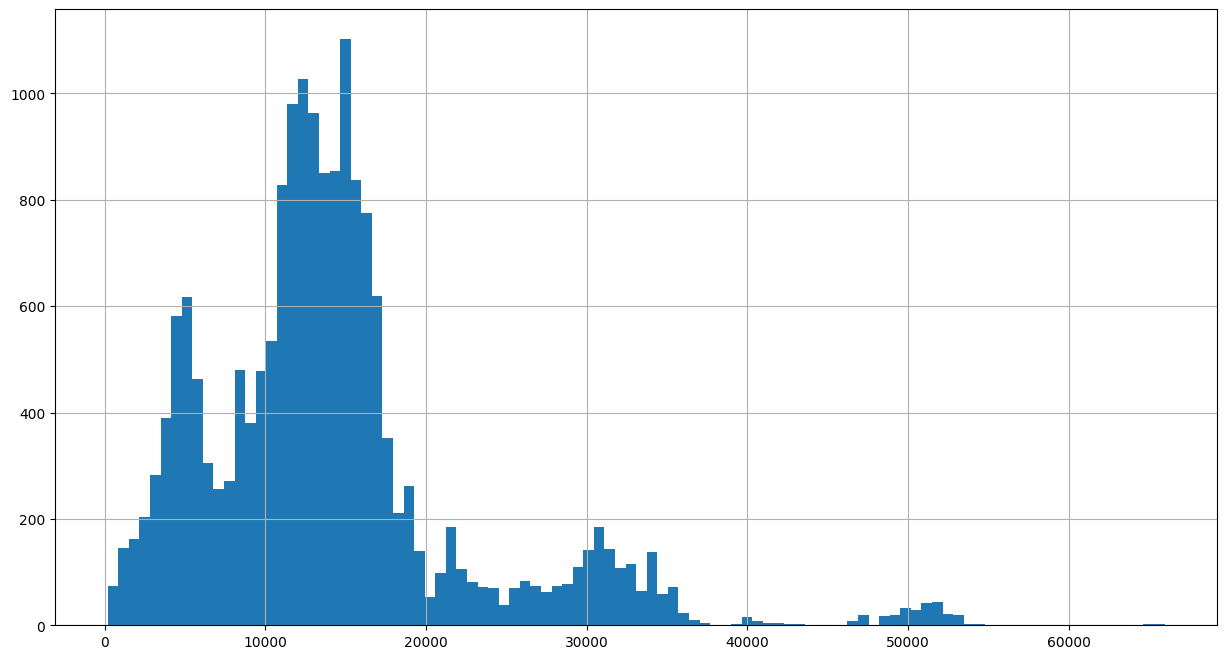

In [33]:
data['cityCenters_nearest'].hist(bins=100, figsize=(15,8))

В основном это 10-20 тысяч метров (то есть километров) до центра, но есть как и более близкие объекты, так и дальние

<Axes: >

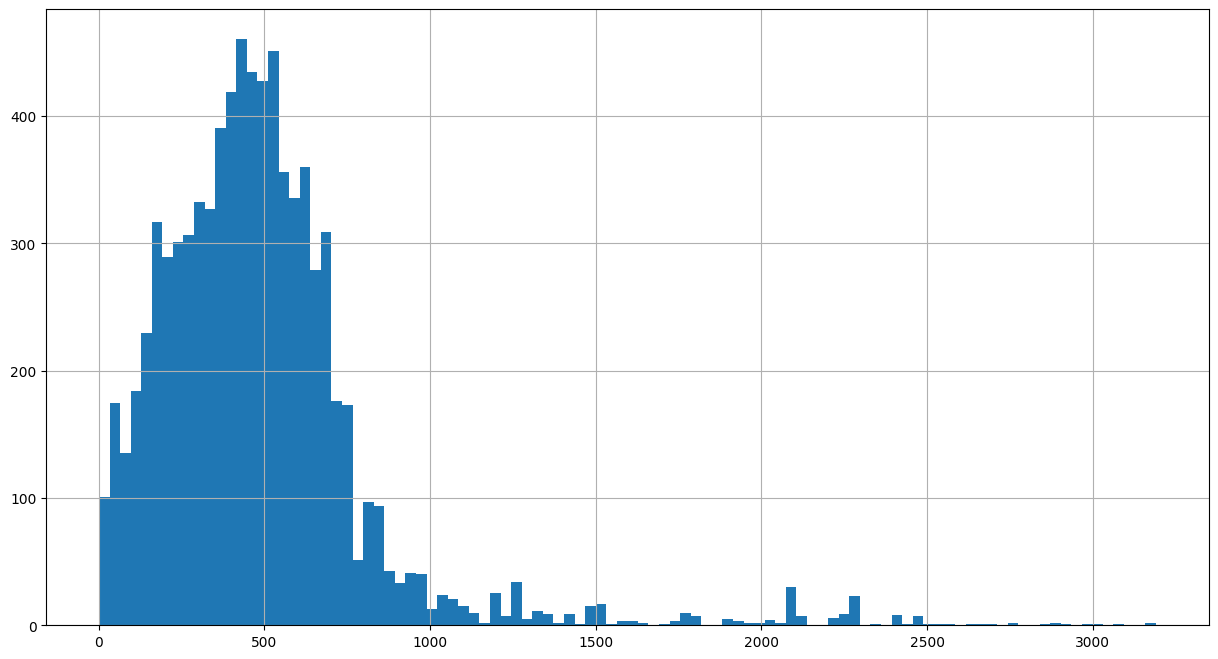

In [34]:
data['parks_nearest'].hist(bins=100, figsize=(15,8))

Видим, что в основном парки находятся в радиусе километра. Но видя очень маленьние значения в частоте (оси y), вспоминаем, что этот столбец слабо заполнен, всего 8 тысяч из 23, у остальных квартир видимо нет рядом парков

___
**Задача 2**
*Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 
Построим гистограмму, посчитаем среднее и медиану.
Опишем, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими.*
___

<Axes: >

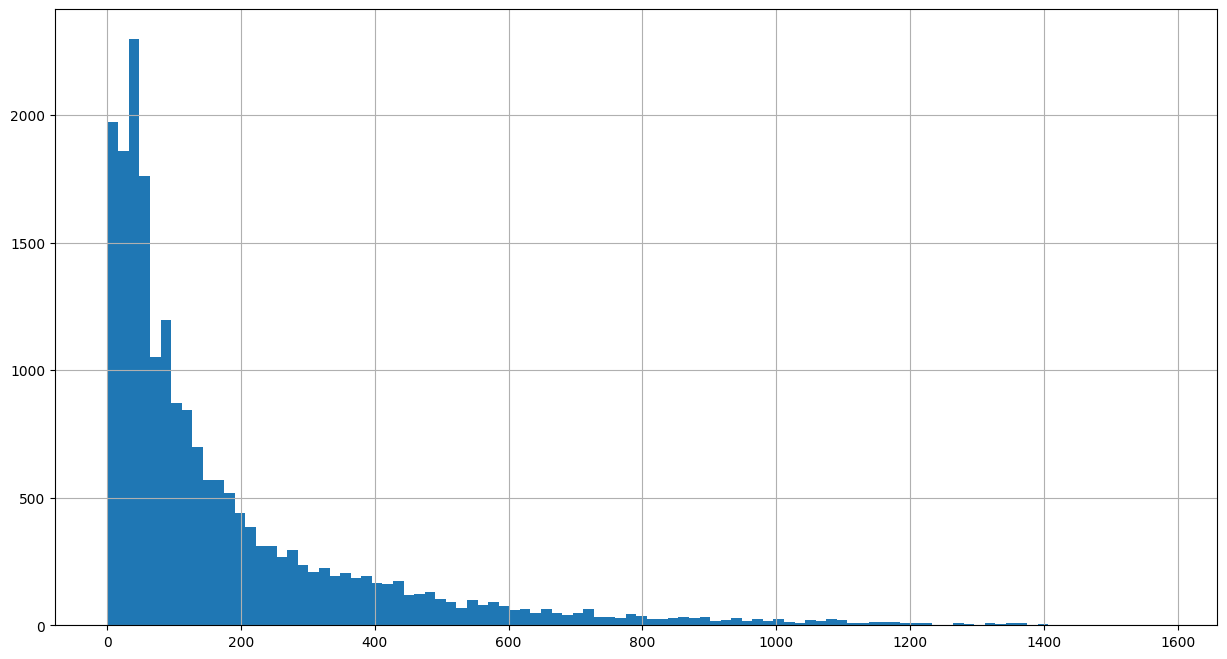

In [35]:
data['days_exposition'].hist(bins=100, figsize=(15,8))

Рассмотрим подробнее первую часть графика от 0 до 100 дней

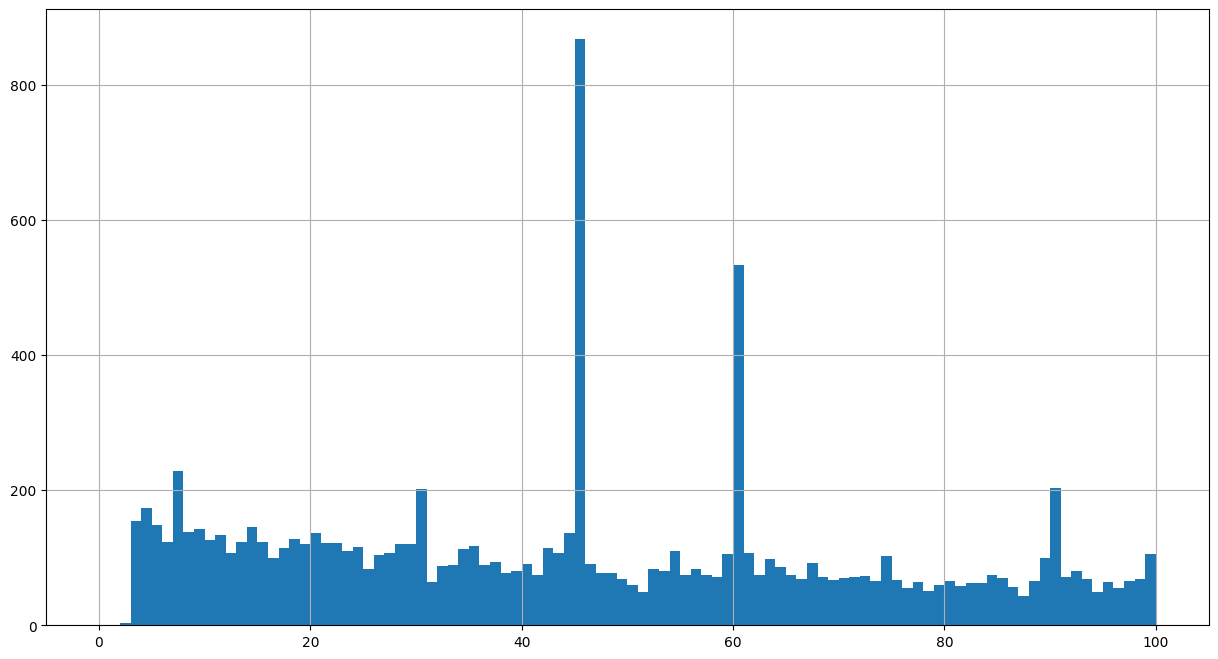

In [36]:
data['days_exposition'].hist(bins=100, figsize=(15,8), range=(0,100))
plt.show()

Видим выбивающиеся значения на 45 и 60 днях, что можно объяснить фиксированным сроком размещения объявления, после которого оно закрывается автоматически, что не отображает реальные сроки продажи, удалять их неправильно, просто не будем учитывать в анализе.

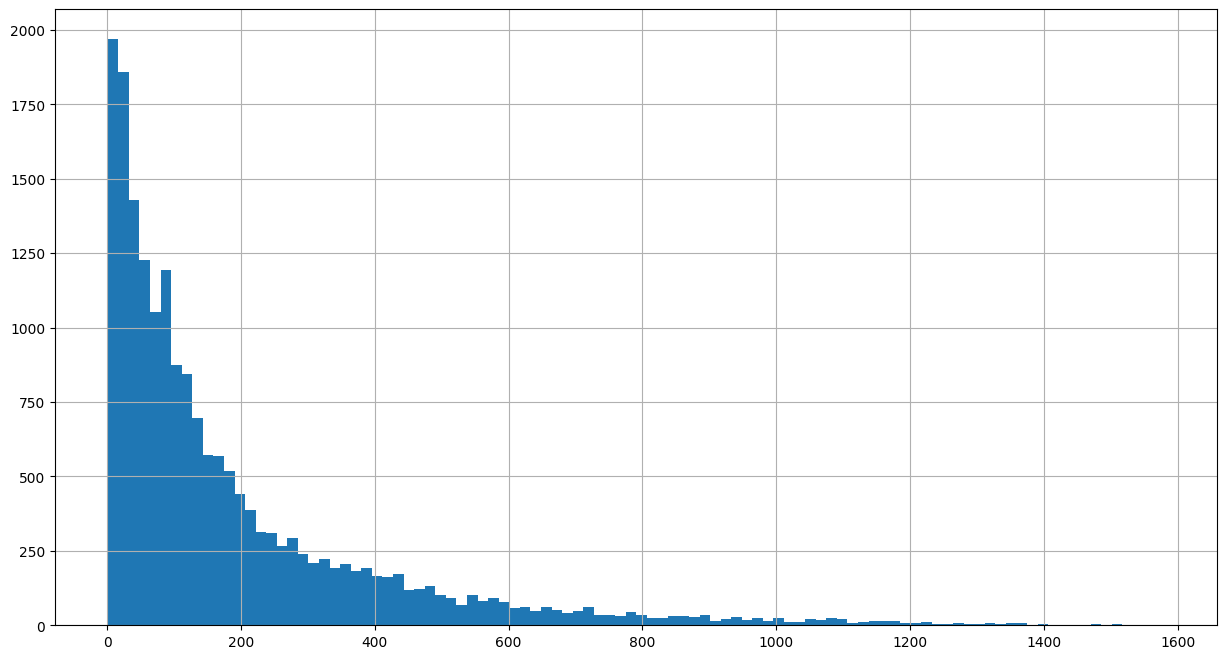

In [37]:
data_days = data.query('days_exposition<44.5 | 45.5<days_exposition<59.5 | days_exposition>60.5')
data_days['days_exposition'].hist(bins=100, figsize=(15,8))
plt.show()

In [38]:
data_days['days_exposition'].describe()

count    18931.000000
mean       191.238128
std        225.093847
min          1.000000
25%         42.000000
50%        109.000000
75%        251.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее значение дней размещения объявления - 191, при этом медианное 109, что показывает, что есть аномально высокие значения. Можно сказать, что обычно продажа занимает немного больше 100 дней, а продажи больше 250 дней (75% в распределении) - необычно долгие

___
**Задача 3**
*Определим факторы, которые больше всего влияют на общую стоимость объекта.
Изучим, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).
Построим графики, которые покажут зависимость цены от указанных выше параметров.*
___

Построим диграммы рассеяния и для числовых данных посчитаем коэффициент корреляции Пирсона.

Сначала рассмотрим площади:

<Axes: xlabel='last_price', ylabel='kitchen_area'>

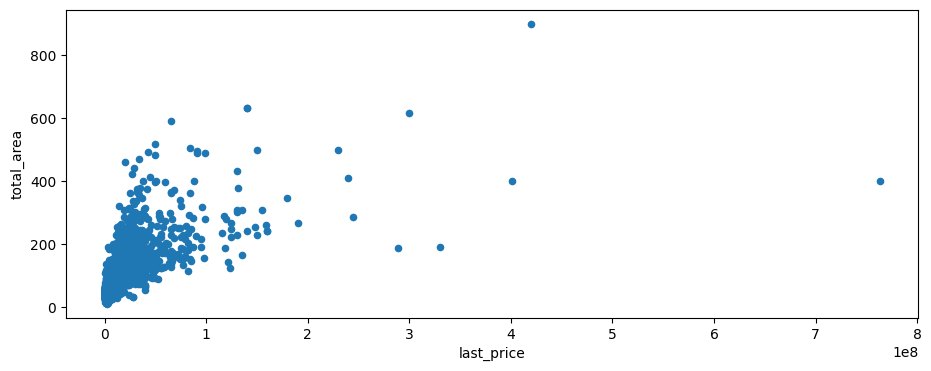

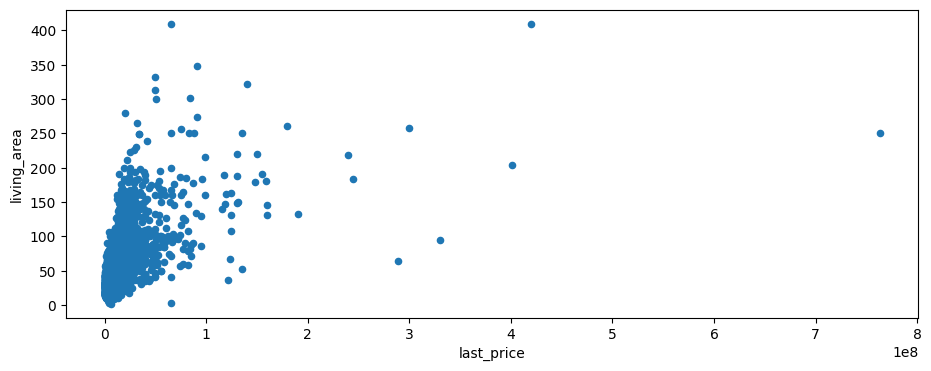

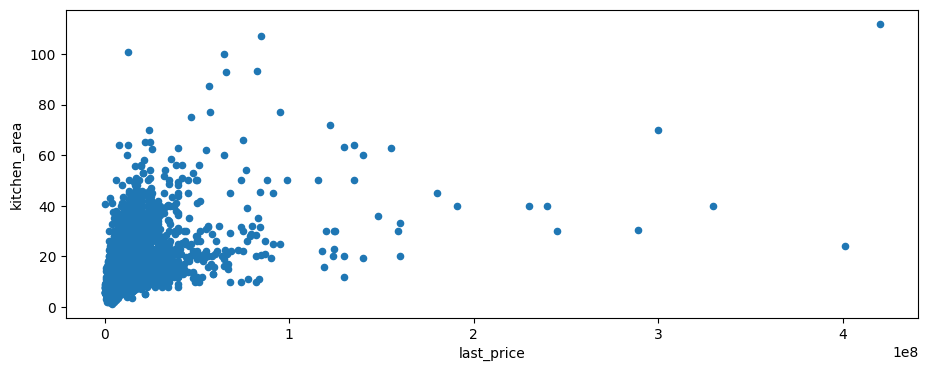

In [39]:
data.plot(x='last_price', y='total_area', kind='scatter', figsize=(11,4))
data.plot(x='last_price', y='living_area', kind='scatter', figsize=(11,4))
data.plot(x='last_price', y='kitchen_area', kind='scatter', figsize=(11,4))

In [40]:
print('Коэффициент корреляции цены от:')
print('общей площади -',data['total_area'].corr(data['last_price']).round(2))
print('жилой площади -',data['living_area'].corr(data['last_price']).round(2))
print('площади кухни -',data['kitchen_area'].corr(data['last_price']).round(2))

Коэффициент корреляции цены от:
общей площади - 0.65
жилой площади - 0.57
площади кухни - 0.52


Цена конечно же засисит от площади квартиры, при этом от общей больше, а от кухонной немного меньше

Далее рассмотрим количество комнат:

<Axes: xlabel='last_price', ylabel='rooms'>

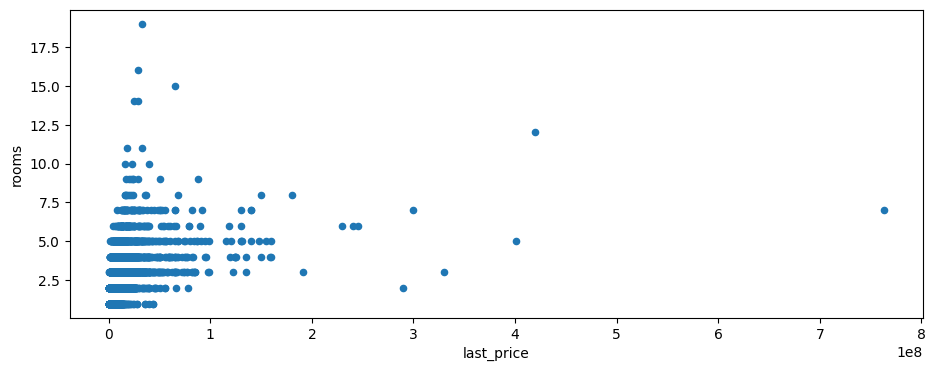

In [41]:
data.plot(x='last_price', y='rooms', kind='scatter', figsize=(11,4))

In [42]:
print('Коэффициент корреляции цены от количества комнат -',data['rooms'].corr(data['last_price']).round(2))

Коэффициент корреляции цены от количества комнат - 0.36


Так же видим, что он количества комнат цена зависит, как и от площади, но в меньшей степени

Далее рассмотрим этаж (первый, последний или другой):

<Axes: xlabel='last_price', ylabel='floor_type'>

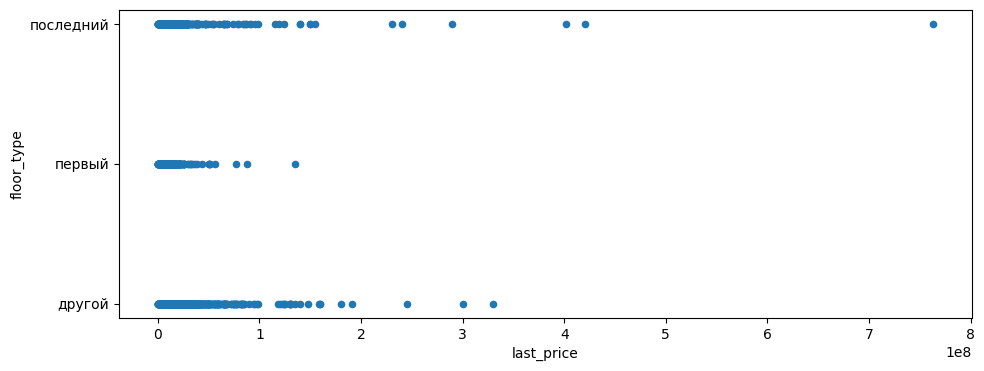

In [43]:
data.plot(x='last_price', y='floor_type', kind='scatter', figsize=(11,4))

По гистограмме видим, что первые этажи стоят дешевле, чем другие и последние. А самая дорогая квартира в подборке похожа на огромный пентхаус, небось ещё и с терассой :)

Далее рассмотрим даты размещения объявления:

<Axes: xlabel='last_price', ylabel='year_exp'>

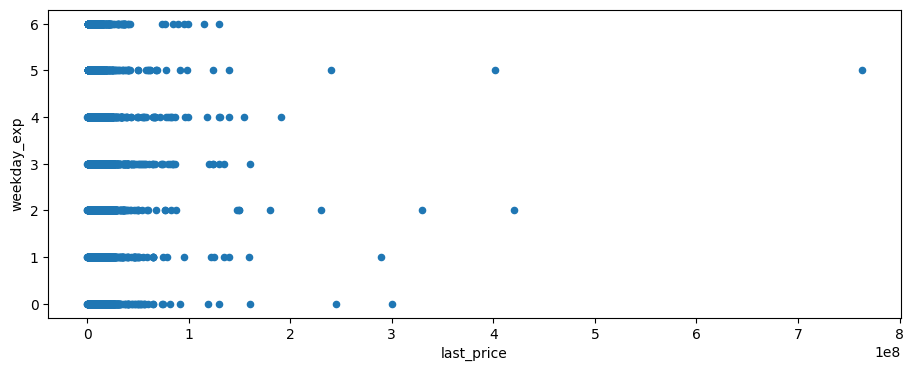

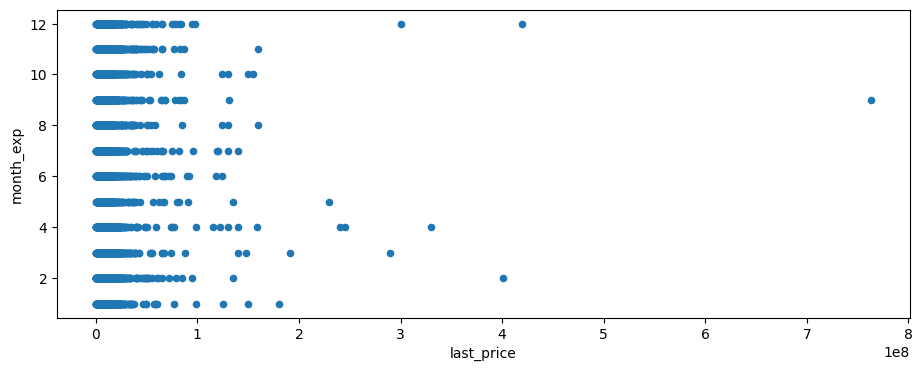

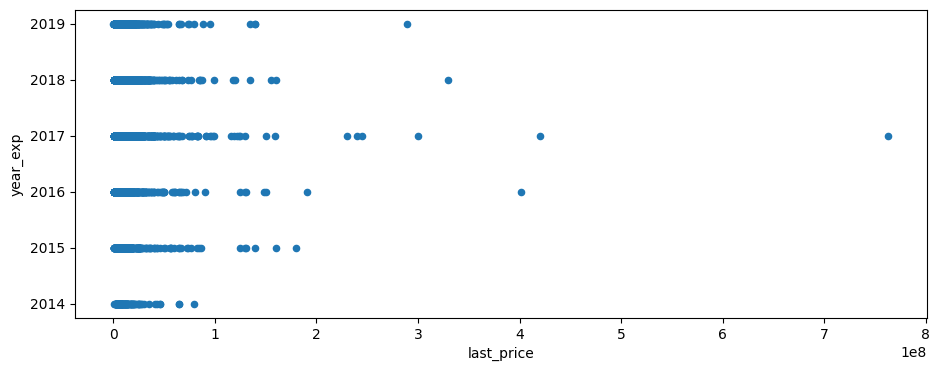

In [44]:
data.plot(x='last_price', y='weekday_exp', kind='scatter', figsize=(11,4))
data.plot(x='last_price', y='month_exp', kind='scatter', figsize=(11,4))
data.plot(x='last_price', y='year_exp', kind='scatter', figsize=(11,4))

Видим, что от ни от дня недели, ни от месяца размещения объявления цена не зависит, а вот от года - видим небольшой рост в сторону увеличения года, что логично, что цены со временем растут

___
**Задача 4**
*Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.*
___

In [45]:
data.groupby(['locality_name'])\
    .agg({'last_price_m2': ['count','mean']})\
    .sort_values(by=[('last_price_m2', 'count')], ascending=False)\
    .head(10)

last_price_m2               
                          count           mean
locality_name                                 
Санкт-Петербург           15610  114757.669372
поселок Мурино              529   85004.057807
поселок Шушары              436   78405.738532
Всеволожск                  392   68618.013724
Пушкин                      369  103125.819377
Колпино                     338   75424.579112
поселок Парголово           323   90289.778019
Гатчина                     307   68746.146515
деревня Кудрово             283   92297.218834
Выборг                      237   58141.909325

Из топ-10 по количеству объявлений самый дорогой квадратный метр в Санкт-Петербурге, а самый дешёвый в Выборге

___
**Задача 5**
*Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра. Учитывая каждый километр расстояния, узнаем среднюю цену квартир в одном километре от центра, в двух и так далее. Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.*
___

Сделаем срез объявлений Санкт-Петербурга и рассчитаем среднюю цену, сгруппировав срез по новому столбцу расстояния от центра в километрах

In [46]:
data_spb = data.query('locality_name=="Санкт-Петербург"')\
    .groupby('cityCenters_nearest_km')['last_price_m2'].agg('mean')
data_spb

cityCenters_nearest_km
0.0     245833.530370
1.0     177327.462304
2.0     158007.626753
3.0     121343.968281
4.0     133339.169025
5.0     140438.067688
6.0     150950.512340
7.0     156275.146435
8.0     124858.964814
9.0     113089.111709
10.0    112732.851439
11.0    108630.835357
12.0    107379.026388
13.0    107907.842806
14.0    103987.144782
15.0    104200.692266
16.0    100458.998081
17.0     96368.116475
18.0     96271.349500
19.0     98703.653677
20.0    101414.915106
21.0     94540.814483
22.0     91330.425099
23.0     91915.247952
24.0     84962.459200
25.0     91531.371154
26.0     89285.877170
27.0    132115.710000
28.0     81161.914286
29.0     72953.365000
Name: last_price_m2, dtype: float64

<Axes: xlabel='cityCenters_nearest_km'>

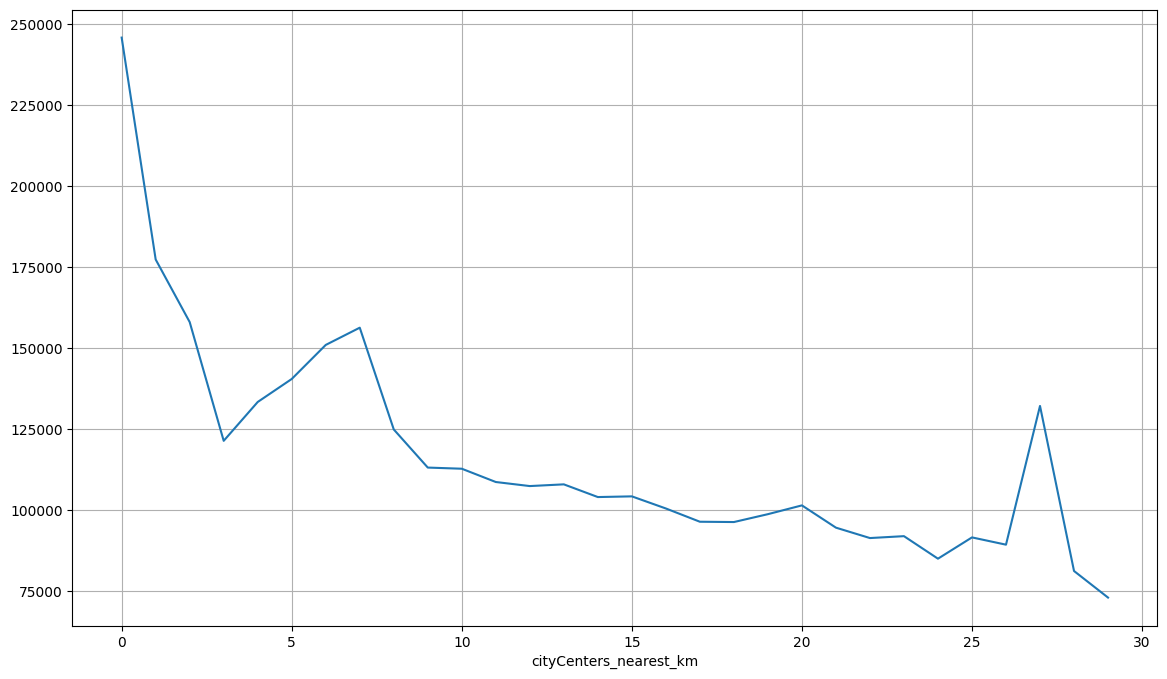

In [47]:
data_spb.plot(x='cityCenters_nearest_km', y='last_price_m2', figsize=(14,8), grid=True)

По сводной таблице и графику зависимости средней цены квадратного метра от расстояния от центра в километрах видим очень дорогие квартиры в самом центре и равномерное снижение цены при удалении, за исключение 4-7ого километров и 27ого, что можно объяснить новыми микрорайонами или жилыми комплексами. После 8 км цена перестает резко падать, что говорит нам о том, что скорее всего зона центра города закончилась.

## Общий вывод

В данном проекте мы работали с данными сервиса Яндекс Недвижимость — архивом объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.  
В таблице у нас есть цены квартир и их основные параметры, которые заполняются пользователем, а также автоматически заполненные данные по адресу квартиры. И там, и там в некоторых столбцах мы обнаружили пропуски, которые могли быть связаны с нежеланием пользователя их заполнять или незнанием, пропуски в автоматически заполняемых данных объясним несовершенством базы данных. Пропуски, которые мы смогли объяснить, мы заполнили, некоторое небольшое количество ошибочных данных удалили.  
Мы изучили уникальные значения в столбце с названиями и устранили неявные дубликаты, например, заменили Ё на Е в слове поселок и объединили в одно название поселок городского типа/городской поселок/поселок.
Добавили новые столбцы, по которым оценили зависимость стоимости квартиры от различных параметров.  
Изучили некоторые числовые параметры объектов, построив гистограммы. В некоторых параметрах были выбивающиеся значения, часть из которых можно было объяснить, другую часть поправили (высоту потолков) или удалили (бескомнатные квартиры).  
Изучили, как быстро продавались квартиры. Проанализировали, какие продажи можно считать быстрыми, а какие — необычно долгими.  
Определили факторы, больше всего влияющие на стоимость квартиры. Это конечно же общая площадь, количество комнат и этаж (выше первого). Также заметили, что с течением времени (года) стоимость растёт.  
Посчитали среднюю цену квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделили населённые пункты с самой высокой и низкой стоимостью квадратного метра среди них.  
И в конце изучили и заметили, как стоимость квартир прямо зависит от расстояния до центра города.